# Setup

In [1]:
include(joinpath("..","src","setup.jl"))

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228


RObject{VecSxp}
$rcalljl_options
$rcalljl_options$height
[1] 360

$rcalljl_options$width
[1] 432




In [2]:
datadir = joinpath("..","data","count_lengths","run_2018-11-26")

"../data/count_lengths/run_2018-11-26"

In [3]:
params = load(joinpath(datadir,"params.jld2"),"params")
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,23.3,1,2018-11-26T17:38:30.128,1
2,23.3,1,2018-11-26T17:40:27.495,1
3,23.3,1,2018-11-26T17:40:30.437,1
4,23.3,1,2018-11-26T17:40:33.359,1
5,23.3,1,2018-11-26T17:40:36.249,1
6,23.3,1,2018-11-26T17:40:39.153,1


# Figure 2

#### TODO:
maybe show multiple models, not just the best; just their means, overlapping as light gray bars, this woudl communicate that the 3st perfect response is an idiosynrchorsy of *some* good fitting modeles, but not all. 

another, potentially simpler option would be to treat each model as one "individual" of a population, and compute the results of this graph over multiple models

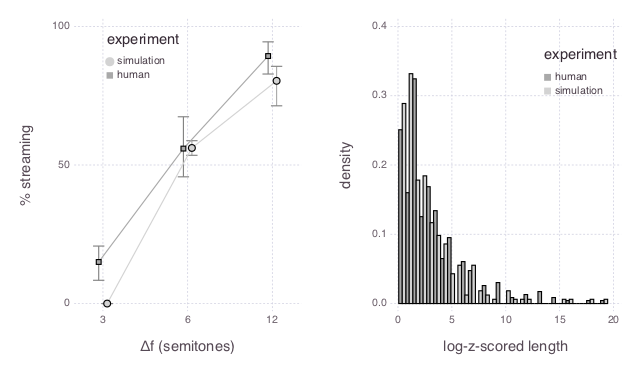

false

In [5]:
p = plot_fit(df,params,t_c_a=5,t_c_m=5)
draw(PDF(joinpath(plotdir,"fig2bc.pdf"),5inch,3inch),p)
draw(PNG(6.666inch,4inch),p)

# Figure 3A

In [ ]:
dfh = setup_human_data();

In [30]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params[fields])))
df_summary = by(params,fields) do row
    next!(progress)
    DataFrame(rms = model_rms(df,params,dfh,N=1,
                      f_c_a=row[1,:f_c_a], f_c_m=row[1,:f_c_m], f_c_σ = row[1,:f_c_σ],
                      s_c_a=row[1,:s_c_a], s_c_m=row[1,:s_c_m], s_c_σ = row[1,:s_c_σ],
                      t_c_a=row[1,:t_c_a], t_c_m=row[1,:t_c_m], t_c_σ = row[1,:t_c_σ]))
end

dfplot = @linq df_summary |>
    rename_levels_for(:rms) |>
    transform(a = packaxes(:c_a), m = packaxes(:c_m)) |>
    transform(rms_str = fmt.("01.2f",:rms))
              
head(dfplot)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


,c_m,c_a,level,rms,a,m,rms_str
,Float64,Float64,String,Float64,Float64,Float64,String
1,0.0,0.0,Peripheral,2.32784,0.0,0.0,2.33
2,5.0,0.0,Peripheral,1.53693,0.0,1.5,1.54
3,15.0,0.0,Peripheral,1.34168,0.0,2.5,1.34
4,44.0,0.0,Peripheral,1.5837,0.0,3.5,1.58
5,130.0,0.0,Peripheral,1.57557,0.0,4.5,1.58
6,390.0,0.0,Peripheral,1.57356,0.0,5.5,1.57


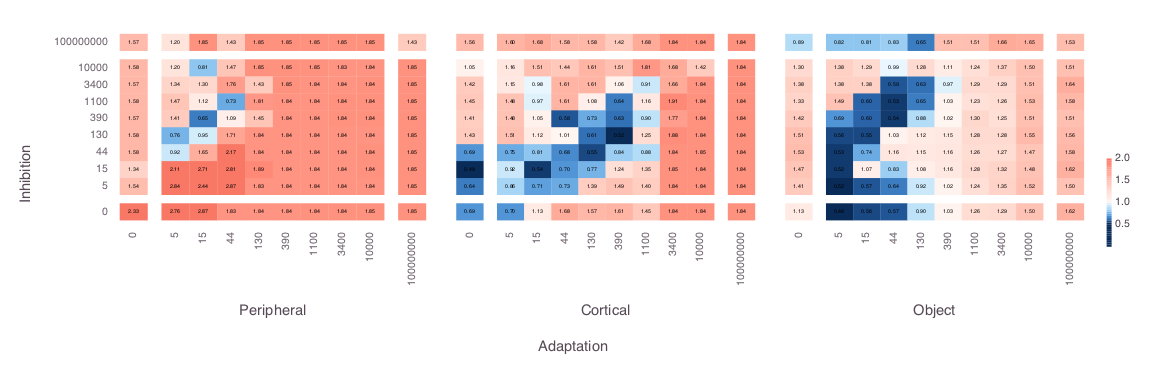

false

In [31]:
xvals = sort!(unique(dfplot.a));
yvals = sort!(unique(dfplot.m));

pl = plot(dfplot,x=:a,y=:m,color=:rms,xgroup=:level,label=:rms_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Scale.x_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot.c_a)),
                       Scale.y_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot.c_m)),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Scale.color_continuous(minvalue=0,maxvalue=2,colormap=colorscale("RdBu",reverse=true,minvalue=0,maxvalue=2,colorstop=2.75,colorstart=0.5,midvalue=1.0)),
     Guide.colorkey(title=""),
     Theme(grid_line_width=0inch,point_label_font_size=4pt,point_label_color=colorant"black"))
draw(PDF(joinpath(plotdir,"fig3A.pdf"),8.5inch,3.5inch),pl)
draw(PNG(12inch,4inch),pl)

# Figure 2B

In [ ]:
num_sims = 20
map(dbootind(num_sims)) do indices
    df_summary = by(@where(params,:Δf .== 6),fields) do row
        rms = model_rms(df,params,dfh,N=1,resample_N=num_sims,resampling=indices,
                      f_c_a=row[1,:f_c_a], f_c_m=row[1,:f_c_m], f_c_σ = row[1,:f_c_σ],
                      s_c_a=row[1,:s_c_a], s_c_m=row[1,:s_c_m], s_c_σ = row[1,:s_c_σ],
                      t_c_a=row[1,:t_c_a], t_c_m=row[1,:t_c_m], t_c_σ = row[1,:t_c_σ])
    end
    # TODO: compute mean and min for each level
end
# TODO: compute confidence intervals of mean and min